# iModulon Characterization:
# iModulons with KEGG Enrichements

## Setup
This IPython notebook continues from the initial iModulon Characterization notebook and will walk through the steps of characterizing iModulons through semi-automated tools, specifically through known KEGG enrichments (based on genes present in particular iModulons). You will need:

* M and A matrices
* Expression data (e.g. `log_tpm_norm.csv`)
* Gene table and KEGG/GO annotations (Generated in `gene_annotation.ipynb`)
* Sample table, with a column for `project` and `condition`
* TRN file

In [1]:
from os import path
import pandas as pd
import numpy as np

from tqdm.notebook import tqdm
from pymodulon.core import IcaData
from pymodulon.util import explained_variance
from pymodulon.compare import *
from pymodulon.io import *
from pymodulon.plotting import *

In [2]:
# Enter the location of your data here
data_dir = '../data/'

In [3]:
# Load in metadata & TRN files
df_metadata = pd.read_csv(path.join(data_dir,'metadata_qc.csv'),index_col=0)
df_trn = pd.read_csv(path.join(data_dir,'saci_trn_curated_01_01_2021.tsv'),sep='\t')

# Load in other files to generate IcaData object
ica_data = IcaData(M = path.join(data_dir,'ica_runs/80/S.csv'),
                   A = path.join(data_dir,'ica_runs/80/A.csv'),
                   X = path.join(data_dir,'log_tpm_norm.csv'),
                   gene_table = path.join(data_dir,'gene_info_curated_Jan_07_2021.tsv'),
                   sample_table = path.join(data_dir,'metadata_qc.csv'),
                   trn = path.join(data_dir,'saci_trn_curated_01_01_2021.tsv'),
                   threshold_method = 'kmeans')

### iModulon Table Setup

In [4]:
# Compute TRN enrichment, save enrichment data into imodulon table, rename long imod name to shorter one
ica_data.compute_trn_enrichment(max_regs=4, save=True, force=True)
ica_data.compute_regulon_enrichment(27,'ArnR+ArnR1+ArnA+ArnB',save=True)
reg_entries = ica_data.imodulon_table[ica_data.imodulon_table.regulator.notnull()]
ica_data.rename_imodulons(reg_entries.regulator.to_dict())
ica_data.rename_imodulons({'ArnR+ArnR1+ArnA+ArnB':'ArnRAB'})

# Add single_gene_imodulons and them to imodulon table
sg_imods = ica_data.find_single_gene_imodulons(save=True)
for i,mod in enumerate(sg_imods):
    ica_data.rename_imodulons({mod:'single_gene_'+str(i+1)})

# Rename 'single_gene_3' to FadR-KO
ica_data.rename_imodulons({'single_gene_3':'FadR-KO'})

# Add E coli orthologs to imodulon table
ecoli_data = load_json_model('../example_data/example.json')
dots,links = compare_ica(ecoli_data.M, ica_data.M, cutoff=0.3,
                         ortho_file = '../example_data/example_bbh.csv')

ica_data.imodulon_table['ecoli_ortholog'] = np.nan
for ecoli_mod,target_mod,dist in dots:
    try:
        xx = int(target_mod)
    except ValueError:
        xx = target_mod
    finally:
        ica_data.imodulon_table.loc[xx,'ecoli_ortholog'] = ecoli_mod

ica_data.imodulon_table.loc[[2, 10, 'XylR', 'YtrA', 'LysM', 23, 'FadR-KO', 25, 'ArnRAB', 'FadR', 38]]

,regulator,pvalue,qvalue,precision,recall,f1score,TP,regulon_size,imodulon_size,n_regs,single_gene,ecoli_ortholog
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,OxyR
10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PurR-1
XylR,XylR,3.084629e-11,6.662798e-08,0.212766,0.370370,0.270270,10.0,27.0,47.0,1.0,NaN,GlpR
YtrA,YtrA,2.737665e-13,5.916095e-10,0.243243,0.562500,0.339623,9.0,16.0,37.0,1.0,NaN,NaN
LysM,LysM,9.072731e-10,1.958803e-06,0.400000,0.800000,0.533333,4.0,5.0,10.0,1.0,NaN,NaN
23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CysB
FadR-KO,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,NaN
25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Fur-2
ArnRAB,ArnR+ArnR1+ArnA+ArnB,9.674248e-19,4.713322e-18,0.875000,0.875000,0.875000,7.0,8.0,8.0,4.0,NaN,NaN
FadR,FadR,1.349778e-37,2.914171e-34,0.760000,0.791667,0.775510,19.0,24.0,25.0,1.0,NaN,FadR/IclR


---

## Characterize iModulons by KEGG Enrichments

These iModulons map closely to KEGG enrichment pathways and/or modules

In [5]:
# Load in KEGG enrichment tables
DF_pathway_enrich = pd.read_csv(path.join(data_dir,'kegg_pathway_enrichments.csv'), index_col=0)
DF_module_enrich = pd.read_csv(path.join(data_dir,'kegg_module_enrichments.csv'), index_col=0)

In [6]:
DF_pathway_enrich.head()

,imodulon,kegg_id,pvalue,qvalue,precision,recall,f1score,TP,target_set_size,imodulon_size,pathway_name
0,4,map00740,8.500350e-05,1.674569e-02,0.333333,0.333333,0.333333,2.0,6.0,6.0,Riboflavin metabolism
1,7,map00720,1.947367e-11,3.836313e-09,0.529412,0.169811,0.257143,9.0,53.0,17.0,Carbon fixation pathways in prokaryotes
2,7,map01120,1.296231e-08,1.026232e-06,0.588235,0.067114,0.120482,10.0,149.0,17.0,Microbial metabolism in diverse environments
3,7,map01200,1.562789e-08,1.026232e-06,0.529412,0.082569,0.142857,9.0,109.0,17.0,Carbon metabolism
4,7,map00261,7.608847e-04,2.997886e-02,0.117647,0.333333,0.173913,2.0,6.0,17.0,Monobactam biosynthesis


In [7]:
DF_module_enrich.head()

,imodulon,kegg_id,pvalue,qvalue,precision,recall,f1score,TP,target_set_size,imodulon_size,module_name
0,4,M00125,5.693334e-06,9.678668e-04,0.333333,1.000000,0.500000,2.0,2.0,6.0,"Riboflavin biosynthesis, plants and bacteria, ..."
1,7,M00375,3.286981e-14,5.587867e-12,0.529412,0.321429,0.400000,9.0,28.0,17.0,Hydroxypropionate-hydroxybutylate cycle
2,7,M00374,1.771895e-06,1.506111e-04,0.294118,0.161290,0.208333,5.0,31.0,17.0,Dicarboxylate-hydroxybutyrate cycle
3,7,M00033,3.070233e-04,1.237299e-02,0.117647,0.500000,0.190476,2.0,4.0,17.0,"Ectoine biosynthesis, aspartate => ectoine"
4,7,M00525,5.094759e-04,1.237299e-02,0.117647,0.400000,0.181818,2.0,5.0,17.0,"Lysine biosynthesis, acetyl-DAP pathway, aspar..."


In [8]:
# Custom function (will be useful for characterizing iModulons)
def get_kegg_enrichments(imodulon, kegg_type):
    if kegg_type == 'pathway':
        df = DF_pathway_enrich
    elif kegg_type == 'module':
        df = DF_module_enrich
    else:
        raise ValueError('kegg_type must be either "pathway" or "module"')
    
    cond = df['imodulon'].astype(str) == str(imodulon)
    return df[cond].dropna()

In [9]:
p = set(DF_pathway_enrich.dropna()['imodulon'])
m = set(DF_module_enrich.dropna()['imodulon'])

print('Pathways only: ', p-m)
print('Modules only: ', m-p)
print('Pathways & Modules: ', p.intersection(m))

Pathways only:  {'26', '39', '25'}
Modules only:  set()
Pathways & Modules:  {'4', '23', '21', '31', '9', '10', '17', 'LysM', '7', '19', 'XylR'}


### iModulon 25: Cobalamin (Vit B12) iModulon [E coli Ortholog Fur-2]

In [10]:
ica_data.rename_imodulons({25: 'Cobalamin'})

In [11]:
get_kegg_enrichments(25, 'pathway')

,imodulon,kegg_id,pvalue,qvalue,precision,recall,f1score,TP,target_set_size,imodulon_size,pathway_name
43,25,map02010,0.000013,0.002529,0.3,0.25,0.272727,3.0,12.0,10.0,ABC transporters


<AxesSubplot:xlabel='Gene Start', ylabel='Cobalamin Gene Weight'>

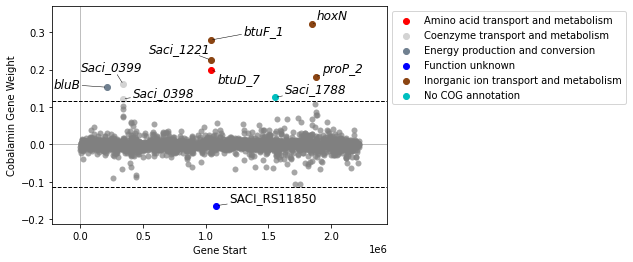

In [12]:
plot_gene_weights(ica_data, 'Cobalamin')

In [13]:
ica_data.view_imodulon('Cobalamin')

,gene_weight,gene_name,old_locus_tag,prokka_locus_tag,synonyms,start,end,strand,gene_product,gene_product_prokka,COG,uniprot,refseq,regulator
SACI_RS01220,0.152986,bluB,Saci_0250,Sacid_00247,NaN,209952.0,210617.0,+,"5,6-dimethylbenzimidazole synthase","5,6-dimethylbenzimidazole synthase",Energy production and conversion,A0A0U2X101,NC_007181.1,NaN
SACI_RS01950,0.121632,Saci_0398,Saci_0398,Sacid_00394,NaN,341130.0,341885.0,-,precorrin-3B C(17)-methyltransferase,Cobalt-factor III methyltransferase,Coenzyme transport and metabolism,A0A0U3HBF9,NC_007181.1,NaN
SACI_RS01955,0.160739,Saci_0399,Saci_0399,Sacid_00395,NaN,341882.0,342883.0,-,precorrin-8X methylmutase,hypothetical protein,Coenzyme transport and metabolism,A0A0U3H2U5,NC_007181.1,NaN
SACI_RS05815,0.279215,btuF_1,Saci_1220,Sacid_01197,NaN,1038318.0,1039313.0,+,ABC transporter substrate-binding protein,Vitamin B12-binding protein,Inorganic ion transport and metabolism,A0A0U3H1G2,NC_007181.1,NaN
SACI_RS05820,0.225851,Saci_1221,Saci_1221,Sacid_01198,NaN,1039531.0,1040529.0,+,iron ABC transporter permease,putative ABC transporter permease protein,Inorganic ion transport and metabolism,A0A0U3GLY8,NC_007181.1,NaN
SACI_RS05825,0.198915,btuD_7,Saci_1222,Sacid_01199,NaN,1040510.0,1041169.0,+,ABC transporter ATP-binding protein,Vitamin B12 import ATP-binding protein BtuD,Amino acid transport and metabolism,A0A0U3HCP3,NC_007181.1,NaN
SACI_RS11850,-0.164215,SACI_RS11850,NaN,NaN,NaN,1083276.0,1083470.0,+,hypothetical protein,NaN,Function unknown,NaN,NC_007181.1,NaN
SACI_RS08550,0.125567,Saci_1788,Saci_1788,Sacid_01754,NaN,1553564.0,1555882.0,+,hypothetical protein,hypothetical protein,No COG annotation,A0A0U3H773,NC_007181.1,NaN
SACI_RS09805,0.320933,hoxN,Saci_2028,Sacid_02022,NaN,1842996.0,1844063.0,-,HoxN/HupN/NixA family nickel/cobalt transporter,High-affinity nickel transport protein,Inorganic ion transport and metabolism,A0A0U3H555,NC_007181.1,NaN
SACI_RS09950,0.181118,proP_2,Saci_2058,Sacid_02053,NaN,1875156.0,1876487.0,-,MFS transporter,Proline/betaine transporter,Inorganic ion transport and metabolism,A0A0U3GPF6,NC_007181.1,NaN


<AxesSubplot:ylabel='Cobalamin iModulon\nActivity'>

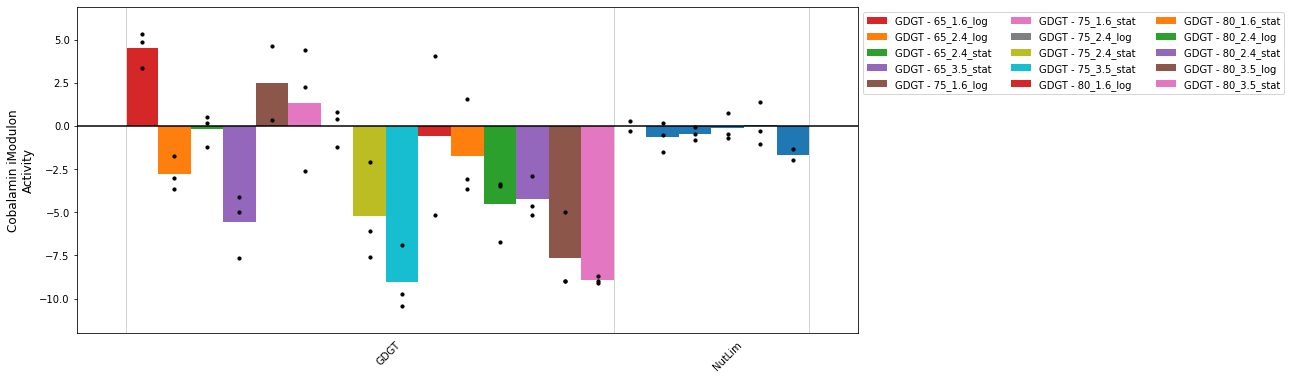

In [14]:
fig, ax = plt.subplots(figsize=(14, 6))

plot_activities(ica_data, 'Cobalamin', projects=['GDGT', 'NutLim'], highlight='GDGT', ax=ax)

### iModulon 26: Putative 4-hydroxyphenylacetate degradation iModulon

In [15]:
ica_data.rename_imodulons({26: '4-HPA'})

In [16]:
get_kegg_enrichments(26, 'pathway')

,imodulon,kegg_id,pvalue,qvalue,precision,recall,f1score,TP,target_set_size,imodulon_size,pathway_name
44,26,map01220,0.000166,0.032736,0.285714,0.285714,0.285714,2.0,7.0,7.0,Degradation of aromatic compounds


<AxesSubplot:xlabel='Gene Start', ylabel='4-HPA Gene Weight'>

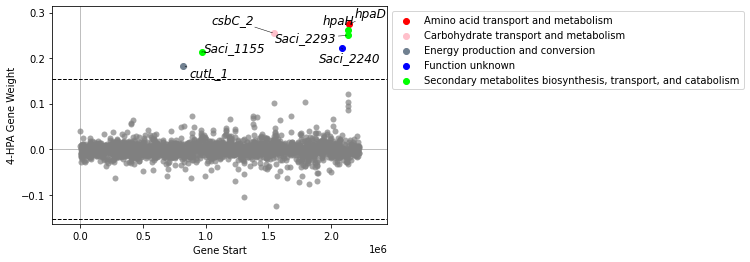

In [17]:
plot_gene_weights(ica_data, '4-HPA')

<AxesSubplot:xlabel='4-HPA'>

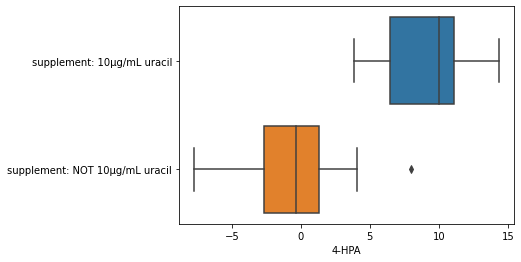

In [18]:
metadata_boxplot(ica_data, '4-HPA', n_boxes=2)

In [19]:
ica_data.view_imodulon('4-HPA')

,gene_weight,gene_name,old_locus_tag,prokka_locus_tag,synonyms,start,end,strand,gene_product,gene_product_prokka,COG,uniprot,refseq,regulator
SACI_RS04870,0.182864,cutL_1,Saci_1020,Sacid_00993,NaN,819407.0,821452.0,+,xanthine dehydrogenase family protein molybdop...,Carbon monoxide dehydrogenase large chain,Energy production and conversion,A0A0U3H1B1,NC_007181.1,NaN
SACI_RS05500,0.213263,Saci_1155,Saci_1155,Sacid_01131,NaN,966891.0,967697.0,+,acetoacetate decarboxylase family protein,hypothetical protein,"Secondary metabolites biosynthesis, transport,...",A0A0U2W2Q3,NC_007181.1,NaN
SACI_RS08525,0.254069,csbC_2,Saci_1782,Sacid_01749,NaN,1547302.0,1548780.0,-,MFS transporter,putative metabolite transport protein CsbC,Carbohydrate transport and metabolism,A0A0U2W123,NC_007181.1,NaN
SACI_RS10830,0.222119,Saci_2240,Saci_2240,Sacid_02241,NaN,2082950.0,2083417.0,-,flavin reductase family protein,Flavin reductase,Function unknown,A0A0U2Y2B5,NC_007181.1,NaN
SACI_RS11095,0.249805,Saci_2293,Saci_2293,Sacid_02295,NaN,2136785.0,2137627.0,-,fumarylacetoacetate hydrolase family protein,hypothetical protein,"Secondary metabolites biosynthesis, transport,...",Q4J6K3,NC_007181.1,YtrA
SACI_RS11100,0.261034,hpaH,Saci_2294,Sacid_02296,hpaA,2137633.0,2139105.0,-,4-hydroxyphenylacetate 3-hydroxylase family pr...,Anthranilate 3-monooxygenase oxygenase component,"Secondary metabolites biosynthesis, transport,...",A0A0U2NGH6,NC_007181.1,YtrA
SACI_RS11105,0.273739,hpaD,Saci_2295,Sacid_02297,bphC,2139102.0,2140043.0,-,"3,4-dihydroxyphenylacetate 2,3-dioxygenase","Manganese-dependent 2,3-dihydroxybiphenyl 1,2-...",Amino acid transport and metabolism,A0A0U3HN78,NC_007181.1,YtrA


<AxesSubplot:ylabel='4-HPA iModulon\nActivity'>

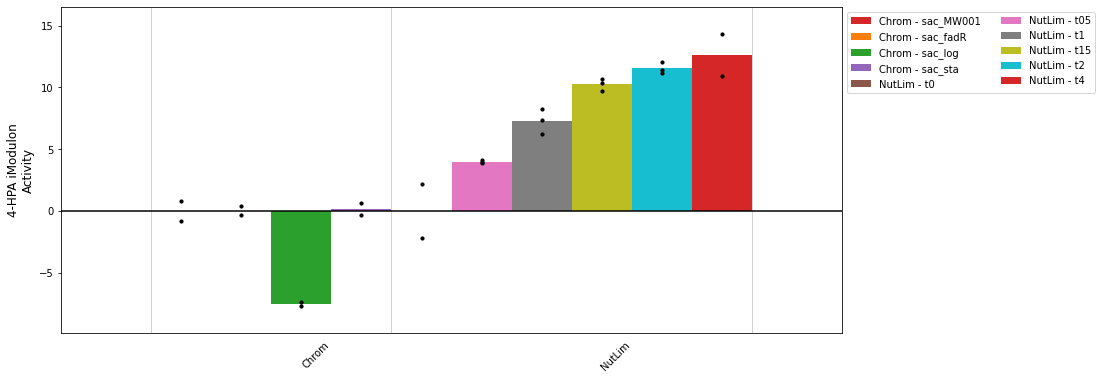

In [20]:
fig, ax = plt.subplots(figsize=(14, 6))

plot_activities(ica_data, '4-HPA', projects=['Chrom', 'NutLim'], highlight=['Chrom', 'NutLim'], ax=ax)

### iModulon 39: Putative Carotenoid Biosynthesis iModulon

### Putative UV-related iModulon, Putative Vit B9 iModulon

In [21]:
ica_data.rename_imodulons({39: 'carotenoid'})

In [22]:
get_kegg_enrichments(39, 'pathway')

,imodulon,kegg_id,pvalue,qvalue,precision,recall,f1score,TP,target_set_size,imodulon_size,pathway_name
65,39,map00906,0.000143,0.028264,0.071429,1.0,0.133333,2.0,2.0,28.0,Carotenoid biosynthesis


<AxesSubplot:xlabel='Gene Start', ylabel='carotenoid Gene Weight'>

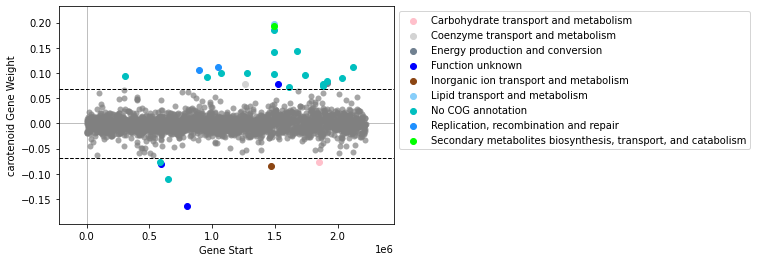

In [23]:
plot_gene_weights(ica_data, 'carotenoid')

In [24]:
ica_data.view_imodulon('carotenoid').sort_values(by='gene_weight', ascending=False)

,gene_weight,gene_name,old_locus_tag,prokka_locus_tag,synonyms,start,end,strand,gene_product,gene_product_prokka,COG,uniprot,refseq,regulator
SACI_RS08285,0.196145,crtB,Saci_1734,Sacid_01698,NaN,1492674.0,1493501.0,+,phytoene/squalene synthase family protein,15-cis-phytoene synthase,Lipid transport and metabolism,A0A0U3FIN4,NC_007181.1,NaN
SACI_RS08275,0.193054,carA2,Saci_1732,Sacid_01696,NaN,1490703.0,1492091.0,-,NAD(P)/FAD-dependent oxidoreductase,zeta-carotene-forming phytoene desaturase,"Secondary metabolites biosynthesis, transport,...",UPI0009B5B9E4,NC_007181.1,NaN
SACI_RS08280,0.186133,Saci_1733,Saci_1733,Sacid_01697,NaN,1492088.0,1492552.0,-,porin,hypothetical protein,No COG annotation,A0A0U2WXF5,NC_007181.1,NaN
SACI_RS09075,0.144157,SACI_RS09075,NaN,Sacid_01859,NaN,1680334.0,1680588.0,-,hypothetical protein,hypothetical protein,No COG annotation,A0A0U3H6Y4,NC_007181.1,NaN
SACI_RS08290,0.142070,Saci_1735,Saci_1735,Sacid_01699,NaN,1493516.0,1494178.0,+,lycopene cyclase domain-containing protein,hypothetical protein,No COG annotation,A0A0U3FAF1,NC_007181.1,NaN
SACI_RS05850,0.111645,phrA,Saci_1227,Sacid_01204,NaN,1043234.0,1044526.0,+,deoxyribodipyrimidine photo-lyase,Deoxyribodipyrimidine photo-lyase,"Replication, recombination and repair",A0A0U3H8Q2,NC_007181.1,NaN
SACI_RS11030,0.111114,Saci_2280,Saci_2280,Sacid_02282,NaN,2124445.0,2124966.0,+,hypothetical protein,hypothetical protein,No COG annotation,A0A0U3FGR2,NC_007181.1,NaN
SACI_RS05225,0.105964,uvsE,Saci_1096,Sacid_01072,NaN,894785.0,895654.0,+,UV DNA damage repair endonuclease UvsE,UV DNA damage endonuclease,"Replication, recombination and repair",A0A0U3FU66,NC_007181.1,NaN
SACI_RS06010,0.100907,SACI_RS06010,NaN,Sacid_01236,NaN,1071231.0,1071434.0,+,hypothetical protein,hypothetical protein,No COG annotation,A0A0U2N8L9,NC_007181.1,NaN
SACI_RS07140,0.100223,upsA,Saci_1496,Sacid_01463,NaN,1275200.0,1275631.0,+,hypothetical protein,hypothetical protein,No COG annotation,A0A0U3FUR0,NC_007181.1,LrpC


<AxesSubplot:ylabel='carotenoid iModulon\nActivity'>

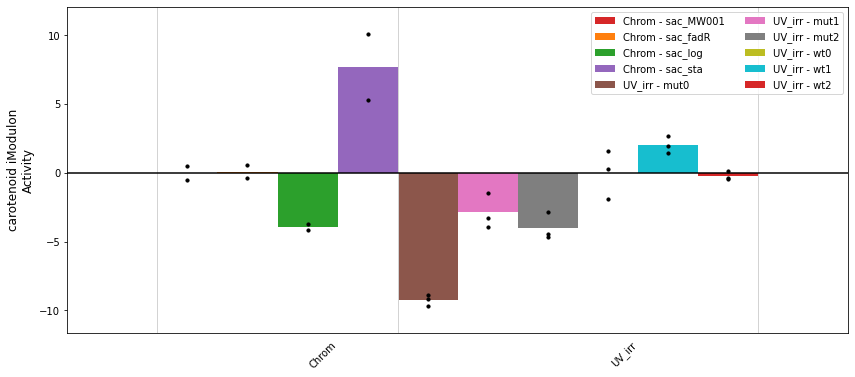

In [25]:
fig, ax = plt.subplots(figsize=(14, 6))

plot_activities(ica_data, 'carotenoid',projects=['Chrom', 'UV_irr'], highlight=['Chrom', 'UV_irr'], ax=ax)

### iModulon 4: Riboflavin iModulon

In [26]:
ica_data.rename_imodulons({4: 'Riboflavin'})

In [27]:
get_kegg_enrichments(4, 'pathway')

,imodulon,kegg_id,pvalue,qvalue,precision,recall,f1score,TP,target_set_size,imodulon_size,pathway_name
0,4,map00740,0.000085,0.016746,0.333333,0.333333,0.333333,2.0,6.0,6.0,Riboflavin metabolism


In [28]:
get_kegg_enrichments(4, 'module')

,imodulon,kegg_id,pvalue,qvalue,precision,recall,f1score,TP,target_set_size,imodulon_size,module_name
0,4,M00125,0.000006,0.000968,0.333333,1.0,0.5,2.0,2.0,6.0,"Riboflavin biosynthesis, plants and bacteria, ..."


<AxesSubplot:xlabel='Gene Start', ylabel='Riboflavin Gene Weight'>

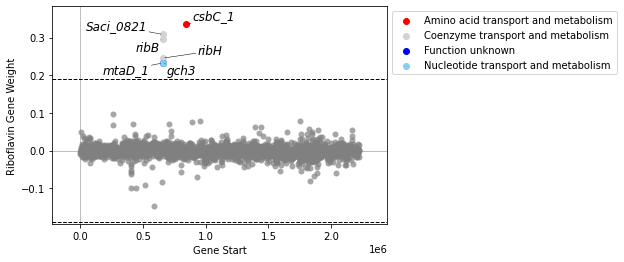

In [29]:
plot_gene_weights(ica_data, 'Riboflavin')

In [30]:
ica_data.view_imodulon('Riboflavin')

,gene_weight,gene_name,old_locus_tag,prokka_locus_tag,synonyms,start,end,strand,gene_product,gene_product_prokka,COG,uniprot,refseq,regulator
SACI_RS03915,0.232396,mtaD_1,Saci_0818,Sacid_00797,NaN,656317.0,657420.0,-,amidohydrolase family protein,5-methylthioadenosine/S-adenosylhomocysteine d...,Nucleotide transport and metabolism,A0A0U2N979,NC_007181.1,NaN
SACI_RS03920,0.233548,gch3,Saci_0819,Sacid_00798,NaN,657402.0,658061.0,-,GTP cyclohydrolase IIa,hypothetical protein,Function unknown,A0A0U2Y7W8,NC_007181.1,NaN
SACI_RS03925,0.245319,ribH,Saci_0820,Sacid_00799,NaN,658058.0,658534.0,-,"6,7-dimethyl-8-ribityllumazine synthase","6,7-dimethyl-8-ribityllumazine synthase",Coenzyme transport and metabolism,UPI00005523C3,NC_007181.1,NaN
SACI_RS03930,0.308090,Saci_0821,Saci_0821,Sacid_00800,NaN,658506.0,658976.0,-,riboflavin synthase,hypothetical protein,Coenzyme transport and metabolism,A0A0U3FF10,NC_007181.1,NaN
SACI_RS03935,0.296197,ribB,Saci_0822,Sacid_00801,NaN,658973.0,659635.0,-,"3,4-dihydroxy-2-butanone-4-phosphate synthase","3,4-dihydroxy-2-butanone 4-phosphate synthase",Coenzyme transport and metabolism,A0A0U3F6Y4,NC_007181.1,NaN
SACI_RS04990,0.334581,csbC_1,Saci_1045,Sacid_01018,NaN,845538.0,846869.0,+,MFS transporter,putative metabolite transport protein CsbC,Amino acid transport and metabolism,A0A0U3FYG8,NC_007181.1,NaN


<AxesSubplot:ylabel='Riboflavin iModulon\nActivity'>

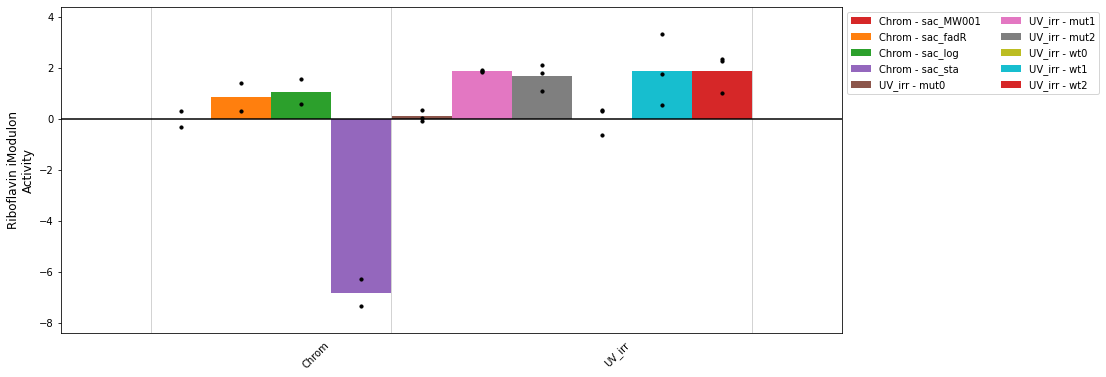

In [31]:
fig, ax = plt.subplots(figsize=(14, 6))

plot_activities(ica_data, 'Riboflavin', projects=['Chrom', 'UV_irr'], highlight=['Chrom', 'UV_irr'], ax=ax)

### iModulon 7: Uncharacterized iModulon 1
### Putative Biotin (Vit B7) / Amino Acid biosynthesis iModulon

In [32]:
ica_data.rename_imodulons({7: 'unchar-1'})

In [33]:
get_kegg_enrichments(7, 'pathway')

,imodulon,kegg_id,pvalue,qvalue,precision,recall,f1score,TP,target_set_size,imodulon_size,pathway_name
1,7,map00720,1.947367e-11,3.836313e-09,0.529412,0.169811,0.257143,9.0,53.0,17.0,Carbon fixation pathways in prokaryotes
2,7,map01120,1.296231e-08,1.026232e-06,0.588235,0.067114,0.120482,10.0,149.0,17.0,Microbial metabolism in diverse environments
3,7,map01200,1.562789e-08,1.026232e-06,0.529412,0.082569,0.142857,9.0,109.0,17.0,Carbon metabolism
4,7,map00261,7.608847e-04,2.997886e-02,0.117647,0.333333,0.173913,2.0,6.0,17.0,Monobactam biosynthesis
5,7,map00280,6.203662e-04,2.997886e-02,0.176471,0.125000,0.146341,3.0,24.0,17.0,"Valine, leucine and isoleucine degradation"
6,7,map00640,1.465411e-03,4.811434e-02,0.176471,0.093750,0.122449,3.0,32.0,17.0,Propanoate metabolism


In [34]:
get_kegg_enrichments(7, 'module')

,imodulon,kegg_id,pvalue,qvalue,precision,recall,f1score,TP,target_set_size,imodulon_size,module_name
1,7,M00375,3.286981e-14,5.587867e-12,0.529412,0.321429,0.400000,9.0,28.0,17.0,Hydroxypropionate-hydroxybutylate cycle
2,7,M00374,1.771895e-06,1.506111e-04,0.294118,0.161290,0.208333,5.0,31.0,17.0,Dicarboxylate-hydroxybutyrate cycle
3,7,M00033,3.070233e-04,1.237299e-02,0.117647,0.500000,0.190476,2.0,4.0,17.0,"Ectoine biosynthesis, aspartate => ectoine"
4,7,M00525,5.094759e-04,1.237299e-02,0.117647,0.400000,0.181818,2.0,5.0,17.0,"Lysine biosynthesis, acetyl-DAP pathway, aspar..."
5,7,M00526,5.094759e-04,1.237299e-02,0.117647,0.400000,0.181818,2.0,5.0,17.0,"Lysine biosynthesis, DAP dehydrogenase pathway..."
6,7,M00527,5.094759e-04,1.237299e-02,0.117647,0.400000,0.181818,2.0,5.0,17.0,"Lysine biosynthesis, DAP aminotransferase path..."
7,7,M00741,5.094759e-04,1.237299e-02,0.117647,0.400000,0.181818,2.0,5.0,17.0,"Propanoyl-CoA metabolism, propanoyl-CoA => suc..."
8,7,M00016,1.060599e-03,2.003354e-02,0.117647,0.285714,0.166667,2.0,7.0,17.0,"Lysine biosynthesis, succinyl-DAP pathway, asp..."
9,7,M00017,1.060599e-03,2.003354e-02,0.117647,0.285714,0.166667,2.0,7.0,17.0,"Methionine biosynthesis, aspartate => homoseri..."
10,7,M00018,1.407975e-03,2.393557e-02,0.117647,0.250000,0.160000,2.0,8.0,17.0,"Threonine biosynthesis, aspartate => homoserin..."


<AxesSubplot:xlabel='Gene Start', ylabel='unchar-1 Gene Weight'>

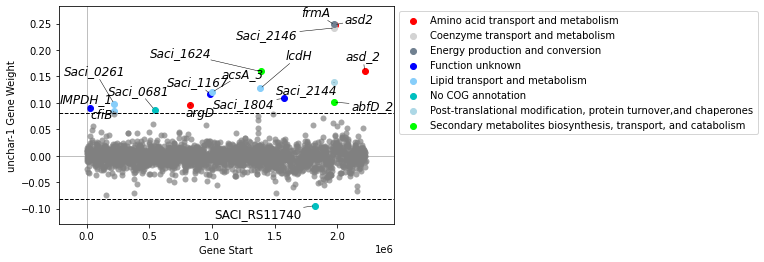

In [35]:
plot_gene_weights(ica_data, 'unchar-1')

In [36]:
ica_data.view_imodulon('unchar-1')

,gene_weight,gene_name,old_locus_tag,prokka_locus_tag,synonyms,start,end,strand,gene_product,gene_product_prokka,COG,uniprot,refseq,regulator
SACI_RS00195,0.090103,IMPDH_1,Saci_0044,Sacid_00042,NaN,29614.0,30108.0,+,CBS domain-containing protein,Inosine-5'-monophosphate dehydrogenase,Function unknown,A0A0U3GVE4,NC_007181.1,YtrA
SACI_RS01265,0.084405,cfiB,Saci_0260,Sacid_00256,NaN,217169.0,218701.0,+,biotin carboxylase,2-oxoglutarate carboxylase small subunit,Lipid transport and metabolism,A0A0U3H337,NC_007181.1,NaN
SACI_RS01270,0.098617,Saci_0261,Saci_0261,Sacid_00257,NaN,218701.0,219204.0,+,biotin/lipoyl-binding protein,hypothetical protein,Lipid transport and metabolism,A0A0U3GUX2,NC_007181.1,NaN
SACI_RS03240,0.086953,Saci_0681,Saci_0681,Sacid_00662,NaN,541758.0,542003.0,+,hypothetical protein,hypothetical protein,No COG annotation,A0A0U3H9V2,NC_007181.1,NaN
SACI_RS04910,0.096804,argD,Saci_1028,Sacid_01002,NaN,827654.0,828943.0,+,acetyl ornithine aminotransferase family protein,Acetylornithine aminotransferase,Amino acid transport and metabolism,A0A0U3HA02,NC_007181.1,NaN
SACI_RS05560,0.116667,Saci_1167,Saci_1167,Sacid_01144,NaN,983366.0,983848.0,-,CBS domain-containing protein,hypothetical protein,Function unknown,A0A0U3FLF0,NC_007181.1,NaN
SACI_RS05645,0.120481,acsA_3,Saci_1184,Sacid_01162,acs,1003003.0,1004967.0,-,acetate--CoA ligase,Acetyl-coenzyme A synthetase,Lipid transport and metabolism,A0A0U3FLD5,NC_007181.1,NaN
SACI_RS07750,0.127476,lcdH,Saci_1623,Sacid_01588,NaN,1386119.0,1387081.0,+,3-hydroxyacyl-CoA dehydrogenase family protein,L-carnitine dehydrogenase,Lipid transport and metabolism,A0A0U3HHE6,NC_007181.1,NaN
SACI_RS07755,0.159463,Saci_1624,Saci_1624,Sacid_01589,NaN,1387132.0,1387698.0,-,cupin domain-containing protein,hypothetical protein,"Secondary metabolites biosynthesis, transport,...",A0A0U3H0Q0,NC_007181.1,NaN
SACI_RS08640,0.108396,Saci_1804,Saci_1804,Sacid_01773,NaN,1571433.0,1571771.0,-,DUF2173 family protein,hypothetical protein,Function unknown,A0A0U2NBH2,NC_007181.1,NaN


<AxesSubplot:ylabel='unchar-1 iModulon\nActivity'>

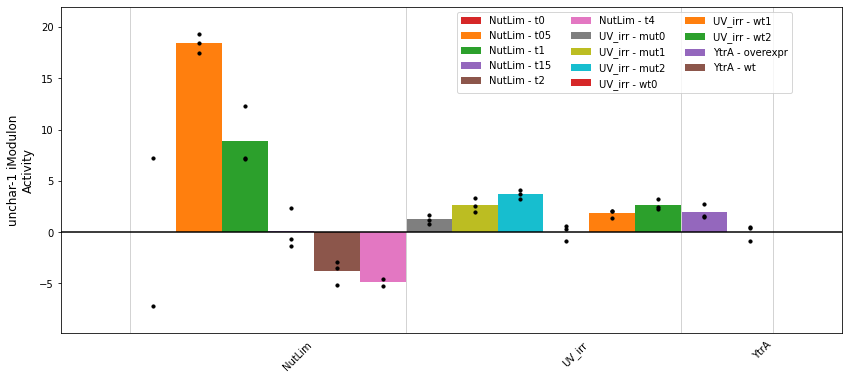

In [37]:
fig, ax = plt.subplots(figsize=(14, 6))

plot_activities(ica_data, 'unchar-1', projects=['NutLim', 'UV_irr', 'YtrA'], 
                highlight=['NutLim', 'UV_irr', 'YtrA'], ax=ax,
                legend_kwargs={'bbox_to_anchor': (0.5, 1)})

### iModulon 9: HMG-CoA / BCAA iModulon

In [38]:
ica_data.rename_imodulons({9: 'HMG-CoA'})

In [39]:
get_kegg_enrichments(9, 'pathway')

,imodulon,kegg_id,pvalue,qvalue,precision,recall,f1score,TP,target_set_size,imodulon_size,pathway_name
7,9,map00900,0.000003,0.000543,0.6,0.187500,0.285714,3.0,16.0,5.0,Terpenoid backbone biosynthesis
8,9,map00072,0.000170,0.016707,0.4,0.200000,0.266667,2.0,10.0,5.0,Synthesis and degradation of ketone bodies
9,9,map00280,0.001028,0.067480,0.4,0.083333,0.137931,2.0,24.0,5.0,"Valine, leucine and isoleucine degradation"
10,9,map00650,0.001834,0.085801,0.4,0.062500,0.108108,2.0,32.0,5.0,Butanoate metabolism
11,9,map04976,0.002178,0.085801,0.2,1.000000,0.333333,1.0,1.0,5.0,Bile secretion


In [40]:
get_kegg_enrichments(9, 'module')

,imodulon,kegg_id,pvalue,qvalue,precision,recall,f1score,TP,target_set_size,imodulon_size,module_name
11,9,M00095,0.000001,0.000240,0.6,0.230769,0.333333,3.0,13.0,5.0,"C5 isoprenoid biosynthesis, mevalonate pathway"
12,9,M00088,0.000170,0.014417,0.4,0.200000,0.266667,2.0,10.0,5.0,"Ketone body biosynthesis, acetyl-CoA => acetoa..."


<AxesSubplot:xlabel='Gene Start', ylabel='HMG-CoA Gene Weight'>

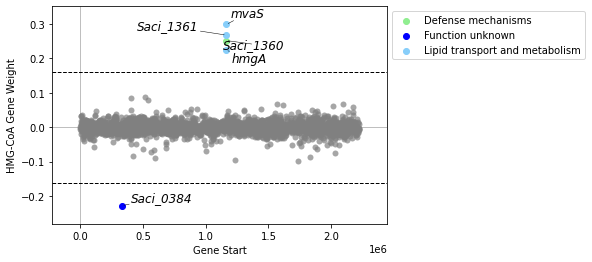

In [41]:
plot_gene_weights(ica_data, 'HMG-CoA')

In [42]:
ica_data.view_imodulon('HMG-CoA')

,gene_weight,gene_name,old_locus_tag,prokka_locus_tag,synonyms,start,end,strand,gene_product,gene_product_prokka,COG,uniprot,refseq,regulator
SACI_RS01880,-0.228067,Saci_0384,Saci_0384,Sacid_00380,NaN,331631.0,331996.0,+,DUF2203 domain-containing protein,hypothetical protein,Function unknown,A0A0U3HEK3,NC_007181.1,NaN
SACI_RS06500,0.224299,hmgA,Saci_1359,Sacid_01333,NaN,1161400.0,1162635.0,-,hydroxymethylglutaryl-CoA reductase (NADPH),hypothetical protein,Lipid transport and metabolism,A0A0U3FV32,NC_007181.1,NaN
SACI_RS06505,0.252092,Saci_1360,Saci_1360,Sacid_01334,NaN,1162619.0,1163032.0,-,Zn-ribbon domain-containing OB-fold protein,hypothetical protein,Defense mechanisms,A0A0U3H6A0,NC_007181.1,NaN
SACI_RS06510,0.267876,Saci_1361,Saci_1361,Sacid_01335,NaN,1163038.0,1164132.0,-,thiolase family protein,hypothetical protein,Lipid transport and metabolism,A0A0U2Y6H3,NC_007181.1,NaN
SACI_RS06515,0.298705,mvaS,Saci_1362,Sacid_01336,NaN,1164132.0,1165178.0,-,hydroxymethylglutaryl-CoA synthase,Hydroxymethylglutaryl-CoA synthase,Lipid transport and metabolism,A0A0U3H6B3,NC_007181.1,NaN


<AxesSubplot:ylabel='HMG-CoA iModulon\nActivity'>

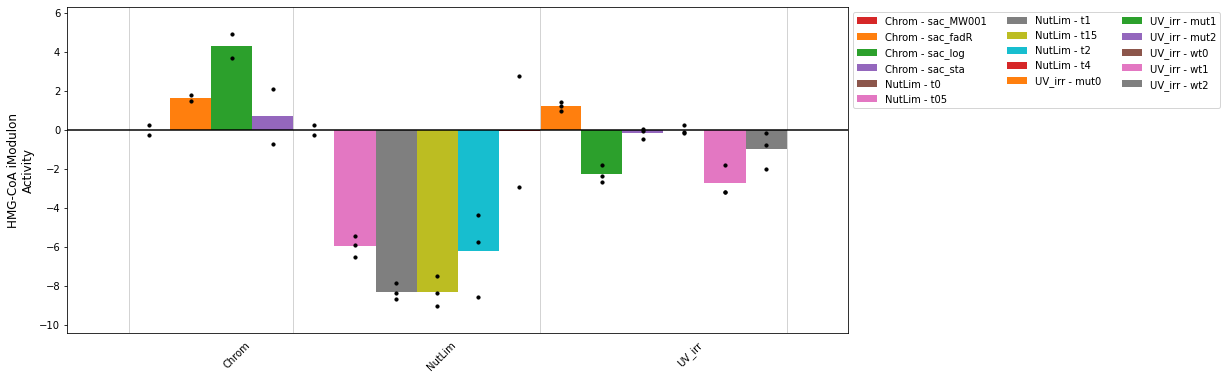

In [43]:
fig, ax = plt.subplots(figsize=(14, 6))

plot_activities(ica_data, 'HMG-CoA', projects=['Chrom', 'NutLim', 'UV_irr'],
                highlight=['Chrom', 'NutLim', 'UV_irr'], ax=ax)

### iModulon 10: Purine biosynthesis iModulon PurR [E coli ortholog: PurR-1]

In [44]:
ica_data.rename_imodulons({10: 'PurR'})

In [45]:
get_kegg_enrichments(10, 'pathway')

,imodulon,kegg_id,pvalue,qvalue,precision,recall,f1score,TP,target_set_size,imodulon_size,pathway_name
13,10,map00230,4.706404e-08,0.000009,0.714286,0.111111,0.192308,5.0,45.0,7.0,Purine metabolism
15,10,map01110,4.260217e-05,0.002798,0.714286,0.028902,0.055556,5.0,173.0,7.0,Biosynthesis of secondary metabolites


In [46]:
get_kegg_enrichments(10, 'module')

,imodulon,kegg_id,pvalue,qvalue,precision,recall,f1score,TP,target_set_size,imodulon_size,module_name
13,10,M00048,5.075523e-11,8.628390e-09,0.714286,0.384615,0.5,5.0,13.0,7.0,"Inosine monophosphate biosynthesis, PRPP + glu..."


<AxesSubplot:xlabel='Gene Start', ylabel='PurR Gene Weight'>

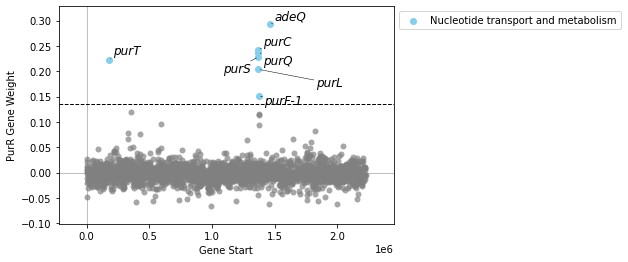

In [47]:
plot_gene_weights(ica_data, 'PurR')

In [48]:
# Manually changing threshold yields more relevant enriched genes for this iModulon
# This is done as the threshold for enrichment is too conservative in this case
ica_data.change_threshold('PurR', 0.08)

<AxesSubplot:xlabel='Gene Start', ylabel='PurR Gene Weight'>

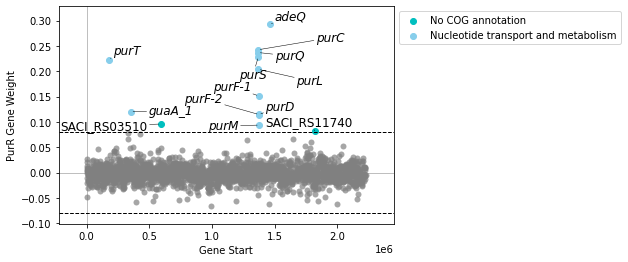

In [49]:
plot_gene_weights(ica_data, 'PurR')

In [50]:
ica_data.view_imodulon('PurR')

,gene_weight,gene_name,old_locus_tag,prokka_locus_tag,synonyms,start,end,strand,gene_product,gene_product_prokka,COG,uniprot,refseq,regulator
SACI_RS01035,0.222913,purT,Saci_0214,Sacid_00208,NaN,176428.0,177624.0,-,formate-dependent phosphoribosylglycinamide fo...,Formate-dependent phosphoribosylglycinamide fo...,Nucleotide transport and metabolism,A0A0U3FGE0,NC_007181.1,NaN
SACI_RS02020,0.119964,guaA_1,Saci_0414,Sacid_00409,NaN,354525.0,355646.0,+,7-cyano-7-deazaguanine synthase,GMP synthase [glutamine-hydrolyzing],Nucleotide transport and metabolism,A0A0U3FP39,NC_007181.1,NaN
SACI_RS03510,0.095766,SACI_RS03510,NaN,Sacid_00716,NaN,590261.0,590485.0,+,hypothetical protein,hypothetical protein,No COG annotation,A0A0U2N9C5,NC_007181.1,NaN
SACI_RS07670,0.242352,purC,Saci_1607,Sacid_01572,NaN,1368285.0,1368992.0,+,phosphoribosylaminoimidazolesuccinocarboxamide...,Phosphoribosylaminoimidazole-succinocarboxamid...,Nucleotide transport and metabolism,A0A0U3GPL6,NC_007181.1,NaN
SACI_RS07675,0.228183,purS,Saci_1608,Sacid_01573,NaN,1368989.0,1369267.0,+,phosphoribosylformylglycinamidine synthase sub...,Phosphoribosylformylglycinamidine synthase sub...,Nucleotide transport and metabolism,A0A0U3H6I0,NC_007181.1,NaN
SACI_RS07680,0.236846,purQ,NaN,Sacid_01574,NaN,1369248.0,1369928.0,+,phosphoribosylformylglycinamidine synthase I,Phosphoribosylformylglycinamidine synthase sub...,Nucleotide transport and metabolism,A0A0U2WXT4,NC_007181.1,NaN
SACI_RS07685,0.203736,purL,Saci_1610,Sacid_01575,NaN,1369918.0,1372050.0,+,phosphoribosylformylglycinamidine synthase sub...,Phosphoribosylformylglycinamidine synthase sub...,Nucleotide transport and metabolism,A0A0U2Y5V4,NC_007181.1,NaN
SACI_RS07690,0.151333,purF-1,Saci_1611,Sacid_01576,purF,1372043.0,1373377.0,+,amidophosphoribosyltransferase,Amidophosphoribosyltransferase,Nucleotide transport and metabolism,A0A0U3H7S7,NC_007181.1,NaN
SACI_RS07695,0.114578,purF-2,Saci_1612,Sacid_01577,NaN,1373383.0,1374597.0,+,amidophosphoribosyltransferase,Amidophosphoribosyltransferase,Nucleotide transport and metabolism,A0A0U3HDH6,NC_007181.1,NaN
SACI_RS07700,0.114411,purD,Saci_1613,Sacid_01578,NaN,1374603.0,1376039.0,+,phosphoribosylamine--glycine ligase,Phosphoribosylamine--glycine ligase,Nucleotide transport and metabolism,A0A0U3FBU2,NC_007181.1,NaN


<AxesSubplot:ylabel='PurR iModulon\nActivity'>

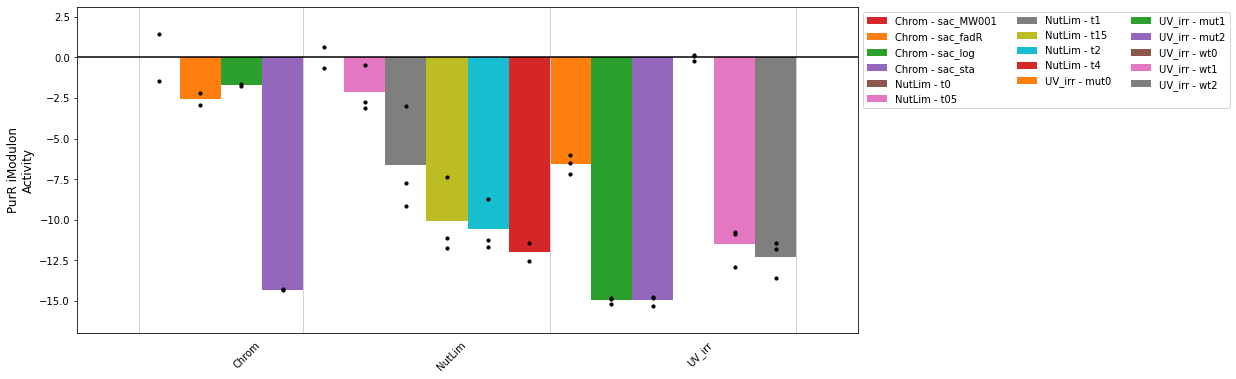

In [51]:
fig, ax = plt.subplots(figsize=(14, 6))

plot_activities(ica_data, 'PurR', projects=['Chrom', 'NutLim', 'UV_irr'],
                highlight=['Chrom', 'NutLim', 'UV_irr'], ax=ax)

### iModulon 17: Ribosome related iModulon 1

### Composite iModulon 1 (Putative Translation + Cell Division + Shikimate iModulon)

In [52]:
ica_data.rename_imodulons({17: 'Ribosome-1'})

In [53]:
get_kegg_enrichments(17, 'pathway')

,imodulon,kegg_id,pvalue,qvalue,precision,recall,f1score,TP,target_set_size,imodulon_size,pathway_name
34,17,map03010,5.303780e-09,0.000001,0.139344,0.278689,0.185792,17.0,61.0,122.0,Ribosome


In [54]:
get_kegg_enrichments(17, 'module')

,imodulon,kegg_id,pvalue,qvalue,precision,recall,f1score,TP,target_set_size,imodulon_size,module_name
27,17,M00022,0.000235,0.013298,0.032787,0.571429,0.062016,4.0,7.0,122.0,"Shikimate pathway, phosphoenolpyruvate + eryth..."


<AxesSubplot:xlabel='Gene Start', ylabel='Ribosome-1 Gene Weight'>

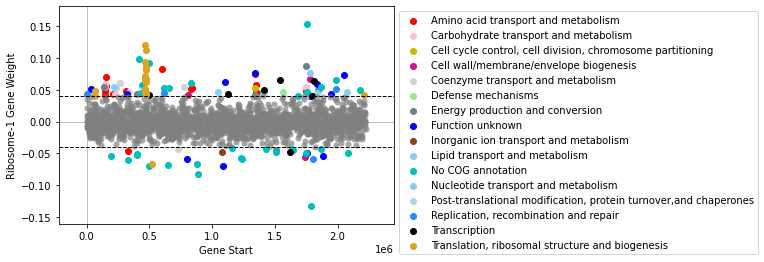

In [55]:
plot_gene_weights(ica_data, 'Ribosome-1')

In [56]:
## Most likely a composite iModulon consisting of some of the following:
## Translation/Ribosome iModulon
## Cell division iModulon
## Shikimate/ Aromatic AA iModulon

<AxesSubplot:ylabel='Ribosome-1 iModulon\nActivity'>

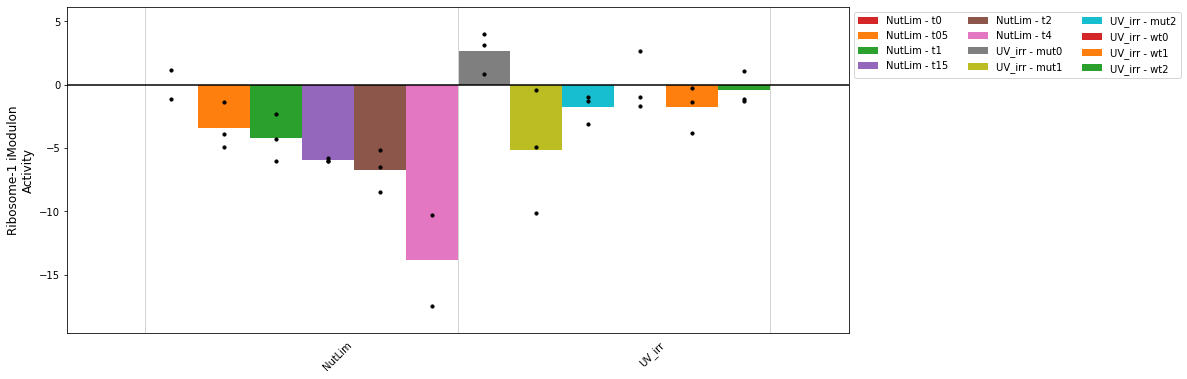

In [57]:
fig, ax = plt.subplots(figsize=(14, 6))

plot_activities(ica_data, 'Ribosome-1', projects=['NutLim', 'UV_irr'], highlight=['NutLim', 'UV_irr'], ax=ax)

### iModulon 19: Arginine biosynthesis iModulon

In [58]:
ica_data.rename_imodulons({19: 'Arginine'})

In [59]:
get_kegg_enrichments(19, 'pathway')

,imodulon,kegg_id,pvalue,qvalue,precision,recall,f1score,TP,target_set_size,imodulon_size,pathway_name
35,19,map00250,5.182310e-09,0.000001,1.0,0.190476,0.320000,4.0,21.0,4.0,"Alanine, aspartate and glutamate metabolism"
36,19,map00220,1.764982e-04,0.017385,0.5,0.153846,0.235294,2.0,13.0,4.0,Arginine biosynthesis
37,19,map01100,8.303681e-04,0.054528,1.0,0.010230,0.020253,4.0,391.0,4.0,Metabolic pathways
38,19,map00240,1.180873e-03,0.058158,0.5,0.060606,0.108108,2.0,33.0,4.0,Pyrimidine metabolism


In [60]:
get_kegg_enrichments(19, 'module')

,imodulon,kegg_id,pvalue,qvalue,precision,recall,f1score,TP,target_set_size,imodulon_size,module_name
28,19,M00029,0.000007,0.000387,0.5,0.666667,0.571429,2.0,3.0,4.0,Urea cycle
29,19,M00844,0.000007,0.000387,0.5,0.666667,0.571429,2.0,3.0,4.0,"Arginine biosynthesis, ornithine => arginine"
30,19,M00845,0.000002,0.000387,0.5,1.000000,0.666667,2.0,2.0,4.0,"Arginine biosynthesis, glutamate => acetylcitr..."
31,19,M00051,0.000064,0.002701,0.5,0.250000,0.333333,2.0,8.0,4.0,"Uridine monophosphate biosynthesis, glutamine ..."


<AxesSubplot:xlabel='Gene Start', ylabel='Arginine Gene Weight'>

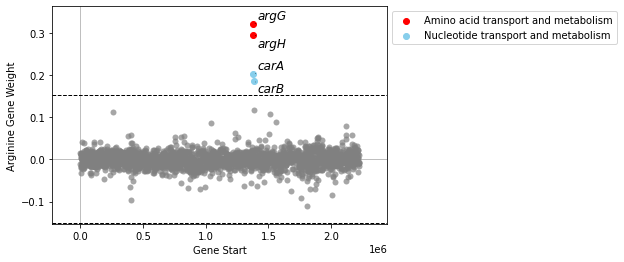

In [61]:
plot_gene_weights(ica_data, 'Arginine')

In [62]:
# Threshold is lowered again in this case to allow for argX
# This threshold is also too conservative which is why it was lowered
ica_data.change_threshold('Arginine', 0.1)

<AxesSubplot:xlabel='Gene Start', ylabel='Arginine Gene Weight'>

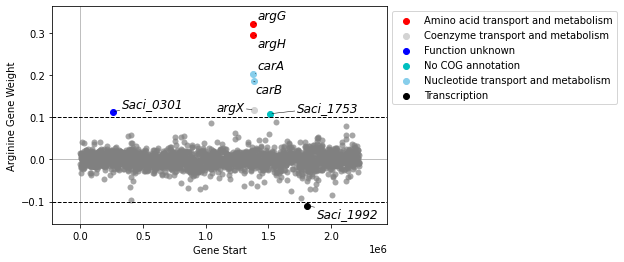

In [63]:
plot_gene_weights(ica_data, 'Arginine')

<AxesSubplot:ylabel='Arginine iModulon\nActivity'>

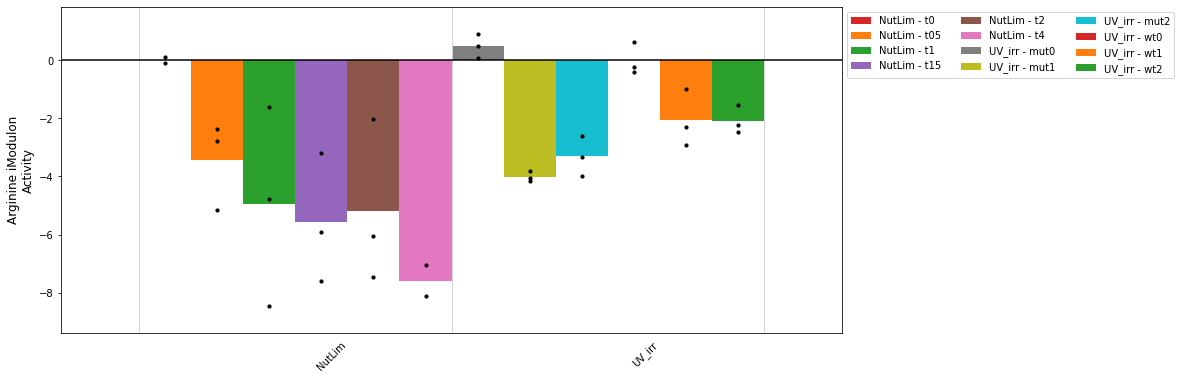

In [64]:
fig, ax = plt.subplots(figsize=(14, 6))

plot_activities(ica_data, 'Arginine', projects=['NutLim', 'UV_irr'], highlight=['NutLim', 'UV_irr'], ax=ax)

### iModulon 21: Ribosome related iModulon 2
### Composite iModulon 2 (Putative Translation + Cell Division + Porphyrin iModulon)

In [65]:
ica_data.rename_imodulons({21: 'Ribosome-2'})

In [66]:
get_kegg_enrichments(21, 'pathway')

,imodulon,kegg_id,pvalue,qvalue,precision,recall,f1score,TP,target_set_size,imodulon_size,pathway_name
39,21,map03010,1.734450e-09,3.416866e-07,0.130137,0.311475,0.183575,19.0,61.0,146.0,Ribosome
40,21,map00970,2.307675e-04,2.273060e-02,0.054795,0.285714,0.091954,8.0,28.0,146.0,Aminoacyl-tRNA biosynthesis


In [67]:
get_kegg_enrichments(21, 'module')

,imodulon,kegg_id,pvalue,qvalue,precision,recall,f1score,TP,target_set_size,imodulon_size,module_name
34,21,M00121,0.000047,0.002641,0.034247,0.625000,0.064935,5.0,8.0,146.0,"Heme biosynthesis, plants and bacteria, glutam..."
37,21,M00159,0.000473,0.013394,0.027397,0.571429,0.052288,4.0,7.0,146.0,"V/A-type ATPase, prokaryotes"
38,21,M00051,0.000899,0.021830,0.027397,0.500000,0.051948,4.0,8.0,146.0,"Uridine monophosphate biosynthesis, glutamine ..."


<AxesSubplot:xlabel='Gene Start', ylabel='Ribosome-2 Gene Weight'>

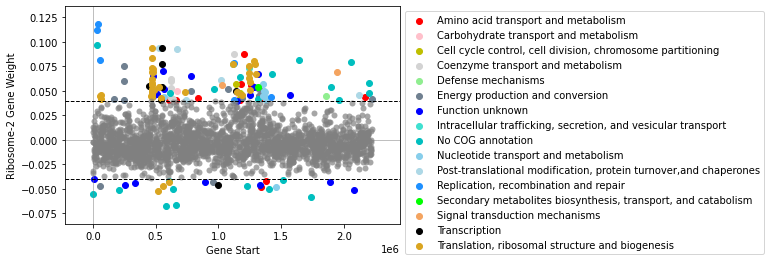

In [68]:
plot_gene_weights(ica_data, 'Ribosome-2')

In [69]:
## Most likely a composite iModulon consisting of some of the following:
## Translation/Ribosome iModulon
## Cell division iModulon
## Porphyrin iModulon

<AxesSubplot:ylabel='Ribosome-2 iModulon\nActivity'>

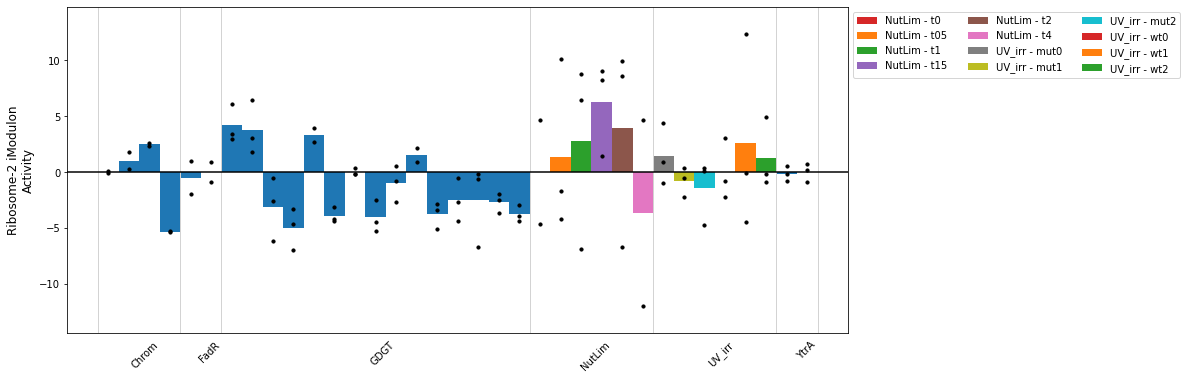

In [70]:
# Very messy activities for this iModulon (esp in NutLim project)
fig, ax = plt.subplots(figsize=(14, 6))

plot_activities(ica_data, 'Ribosome-2', highlight=['NutLim', 'UV_irr'], ax=ax)

### iModulon 23: Sulfur Assimilation iModulon [E coli Ortholog: CysB]

In [71]:
ica_data.rename_imodulons({23: 'sulfur-assimilation'})

In [72]:
get_kegg_enrichments(23, 'pathway')

,imodulon,kegg_id,pvalue,qvalue,precision,recall,f1score,TP,target_set_size,imodulon_size,pathway_name
41,23,map00920,7.583891e-09,0.000001,0.500,0.444444,0.470588,4.0,9.0,8.0,Sulfur metabolism
42,23,map01120,5.148720e-05,0.005071,0.625,0.033557,0.063694,5.0,149.0,8.0,Microbial metabolism in diverse environments


In [73]:
get_kegg_enrichments(23, 'module')

,imodulon,kegg_id,pvalue,qvalue,precision,recall,f1score,TP,target_set_size,imodulon_size,module_name
39,23,M00176,2.779658e-08,0.000005,0.375,1.0,0.545455,3.0,3.0,8.0,"Assimilatory sulfate reduction, sulfate => H2S"


<AxesSubplot:xlabel='Gene Start', ylabel='sulfur-assimilation Gene Weight'>

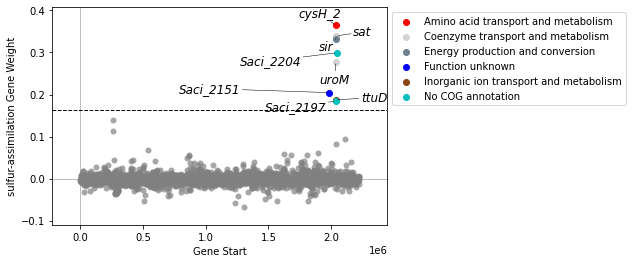

In [74]:
plot_gene_weights(ica_data, 'sulfur-assimilation')

In [75]:
# Threshold may need to be manually curated down to 0.1 to allow mtoX into this iModulon
# For now threshold is not going to be lowered for this case

cond = np.abs(ica_data.M['sulfur-assimilation']) > 0.1

ica_data.gene_table.loc[cond]

,gene_name,old_locus_tag,prokka_locus_tag,synonyms,start,end,strand,gene_product,gene_product_prokka,COG,uniprot,refseq,regulator
SACI_RS01485,Saci_0304,Saci_0304,Sacid_00300,NaN,258506.0,259060.0,-,hypothetical protein,hypothetical protein,No COG annotation,A0A0U2Y921,NC_007181.1,NaN
SACI_RS01490,mtoX,Saci_0305,Sacid_00301,NaN,259029.0,260429.0,-,selenium-binding family protein,Methanethiol oxidase,Function unknown,A0A0U3HAR4,NC_007181.1,NaN
SACI_RS10405,Saci_2151,Saci_2151,Sacid_02149,NaN,1983935.0,1984822.0,+,sulfite exporter TauE/SafE family protein,hypothetical protein,Function unknown,A0A0U3GUX1,NC_007181.1,NaN
SACI_RS10620,Saci_2197,Saci_2197,Sacid_02197,NaN,2036205.0,2036453.0,-,hypothetical protein,hypothetical protein,No COG annotation,A0A0U2VXH2,NC_007181.1,NaN
SACI_RS10625,ttuD,Saci_2198,Sacid_02198,NaN,2036450.0,2037328.0,-,sulfurtransferase,Sulfur carrier protein TtuD,Inorganic ion transport and metabolism,A0A0U2YA58,NC_007181.1,NaN
SACI_RS10635,uroM,Saci_2200,Sacid_02200,cysG_2,2037777.0,2038472.0,-,uroporphyrinogen-III C-methyltransferase,Siroheme synthase,Coenzyme transport and metabolism,A0A0U2NCI9,NC_007181.1,NaN
SACI_RS10640,sir,Saci_2201,Sacid_02201,NaN,2038462.0,2040240.0,-,nitrite/sulfite reductase,Sulfite reductase [ferredoxin],Energy production and conversion,A0A0U2Y2E5,NC_007181.1,NaN
SACI_RS10645,cysH_2,Saci_2202,Sacid_02202,NaN,2040367.0,2041086.0,-,"phosphoadenylyl-sulfate reductase, 5′-adenylyl...",Thioredoxin-dependent 5'-adenylylsulfate reduc...,Amino acid transport and metabolism,A0A0U2X312,NC_007181.1,NaN
SACI_RS10650,sat,Saci_2203,Sacid_02203,NaN,2041202.0,2042437.0,+,sulfate adenylyltransferase,Sulfate adenylyltransferase,Coenzyme transport and metabolism,A0A0U3FXL2,NC_007181.1,NaN
SACI_RS10655,Saci_2204,Saci_2204,Sacid_02204,NaN,2042434.0,2042739.0,+,hypothetical protein,hypothetical protein,No COG annotation,A0A0U2NGN4,NC_007181.1,NaN


### iModulon 31: TCA cycle intermediates / Branched Chain Amino Acid metabolism iModulon
### Putative Carbon/Nitrogen Fixation iModulon

-https://sci-hub.se/https://www.nature.com/articles/nrmicro2365


In [76]:
ica_data.rename_imodulons({31: 'TCA-BCAA'})

In [77]:
get_kegg_enrichments(31, 'pathway')

,imodulon,kegg_id,pvalue,qvalue,precision,recall,f1score,TP,target_set_size,imodulon_size,pathway_name
45,31,map00633,2.649602e-09,5.219716e-07,0.222222,1.000000,0.363636,4.0,4.0,18.0,Nitrotoluene degradation
46,31,map00620,7.801612e-09,7.684587e-07,0.388889,0.175000,0.241379,7.0,40.0,18.0,Pyruvate metabolism
47,31,map00650,7.399756e-08,4.859173e-06,0.333333,0.187500,0.240000,6.0,32.0,18.0,Butanoate metabolism
48,31,map00290,1.261122e-06,6.211026e-05,0.222222,0.333333,0.266667,4.0,12.0,18.0,"Valine, leucine and isoleucine biosynthesis"
49,31,map00010,3.362287e-06,1.103951e-04,0.277778,0.151515,0.196078,5.0,33.0,18.0,Glycolysis / Gluconeogenesis
50,31,map00640,2.866491e-06,1.103951e-04,0.277778,0.156250,0.200000,5.0,32.0,18.0,Propanoate metabolism
51,31,map00020,2.137427e-05,6.015330e-04,0.222222,0.173913,0.195122,4.0,23.0,18.0,Citrate cycle (TCA cycle)
52,31,map01210,3.555836e-05,8.756246e-04,0.222222,0.153846,0.181818,4.0,26.0,18.0,2-Oxocarboxylic acid metabolism
53,31,map00680,6.391307e-05,1.398986e-03,0.222222,0.133333,0.166667,4.0,30.0,18.0,Methane metabolism
55,31,map01100,2.202632e-04,3.944714e-03,0.555556,0.025575,0.048900,10.0,391.0,18.0,Metabolic pathways


In [78]:
get_kegg_enrichments(31, 'module')

,imodulon,kegg_id,pvalue,qvalue,precision,recall,f1score,TP,target_set_size,imodulon_size,module_name
41,31,M00307,3.935652e-08,0.000007,0.222222,0.666667,0.333333,4.0,6.0,18.0,"Pyruvate oxidation, pyruvate => acetyl-CoA"
42,31,M00620,1.261122e-06,0.000107,0.222222,0.333333,0.266667,4.0,12.0,18.0,"Incomplete reductive citrate cycle, acetyl-CoA..."
43,31,M00173,1.186849e-05,0.000673,0.222222,0.200000,0.210526,4.0,20.0,18.0,Reductive citrate cycle (Arnon-Buchanan cycle)
44,31,M00374,7.302165e-05,0.003103,0.222222,0.129032,0.163265,4.0,31.0,18.0,Dicarboxylate-hydroxybutyrate cycle
45,31,M00019,5.726591e-04,0.019470,0.111111,0.400000,0.173913,2.0,5.0,18.0,"Valine/isoleucine biosynthesis, pyruvate => va..."
46,31,M00432,8.549976e-04,0.020764,0.111111,0.333333,0.166667,2.0,6.0,18.0,"Leucine biosynthesis, 2-oxoisovalerate => 2-ox..."
47,31,M00570,8.549976e-04,0.020764,0.111111,0.333333,0.166667,2.0,6.0,18.0,"Isoleucine biosynthesis, threonine => 2-oxobut..."


<AxesSubplot:xlabel='Gene Start', ylabel='TCA-BCAA Gene Weight'>

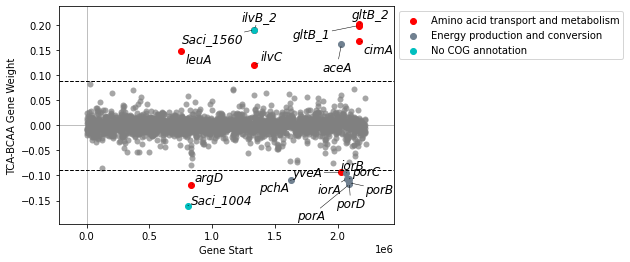

In [79]:
plot_gene_weights(ica_data, 'TCA-BCAA')

In [80]:
ica_data.view_imodulon('TCA-BCAA').sort_values(by='gene_weight', ascending=False)

,gene_weight,gene_name,old_locus_tag,prokka_locus_tag,synonyms,start,end,strand,gene_product,gene_product_prokka,COG,uniprot,refseq,regulator
SACI_RS11235,0.201198,gltB_2,Saci_2321,Sacid_02324,"gltB, purF_3",2169008.0,2170987.0,+,glutamate synthase,Amidophosphoribosyltransferase,Amino acid transport and metabolism,M1IYB3,NC_007181.1,"BarR,LrpC"
SACI_RS11230,0.199034,gltB_1,Saci_2320,Sacid_02323,gltB,2166873.0,2169011.0,+,glutamate synthase,hypothetical protein,Amino acid transport and metabolism,A0A0U3GMR7,NC_007181.1,"BarR,LrpC"
SACI_RS07440,0.191019,ilvB_2,Saci_1561,Sacid_01526,NaN,1333331.0,1335049.0,-,acetolactate synthase large subunit,Acetolactate synthase large subunit,Amino acid transport and metabolism,A0A0U3GJG7,NC_007181.1,NaN
SACI_RS07435,0.190334,Saci_1560,Saci_1560,Sacid_01525,NaN,1332958.0,1333353.0,-,ACT domain-containing protein,hypothetical protein,No COG annotation,A0A0U3FUK9,NC_007181.1,NaN
SACI_RS11255,0.168554,cimA,Saci_2325,Sacid_02328,NaN,2173252.0,2174823.0,+,(R)-citramalate synthase,(R)-citramalate synthase,Amino acid transport and metabolism,A0A0U2Y9V6,NC_007181.1,NaN
SACI_RS10590,0.161409,aceA,Saci_2191,Sacid_02190,NaN,2030804.0,2032117.0,+,isocitrate lyase,Isocitrate lyase,Energy production and conversion,A0A0U3GVW3,NC_007181.1,NaN
SACI_RS04490,0.147968,leuA,Saci_0940,Sacid_00916,NaN,753048.0,754208.0,+,2-isopropylmalate synthase,2-isopropylmalate synthase,Amino acid transport and metabolism,A0A0U3GS85,NC_007181.1,NaN
SACI_RS07430,0.120230,ilvC,Saci_1559,Sacid_01524,NaN,1331979.0,1332977.0,-,Ketol-acid reductoisomerase (NADP(+)),Ketol-acid reductoisomerase (NAD(+)),Amino acid transport and metabolism,A0A0U3H6N8,NC_007181.1,NaN
SACI_RS10580,-0.093555,yveA,Saci_2189,Sacid_02188,NaN,2025549.0,2027396.0,-,APC family permease,Aspartate-proton symporter,Amino acid transport and metabolism,A0A0U3FGY1,NC_007181.1,NaN
SACI_RS10770,-0.094995,iorB,Saci_2228,Sacid_02229,NaN,2070581.0,2071147.0,-,indolepyruvate oxidoreductase subunit beta,hypothetical protein,Energy production and conversion,A0A0U3F977,NC_007181.1,NaN


<AxesSubplot:ylabel='TCA-BCAA iModulon\nActivity'>

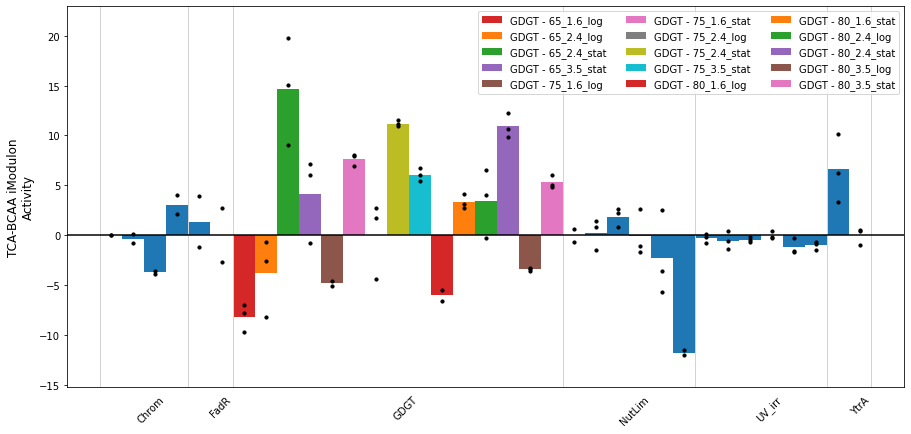

In [81]:
fig, ax = plt.subplots(figsize=(15, 7))

plot_activities(ica_data, 'TCA-BCAA', highlight='GDGT', ax=ax)

<AxesSubplot:ylabel='TCA-BCAA iModulon\nActivity'>

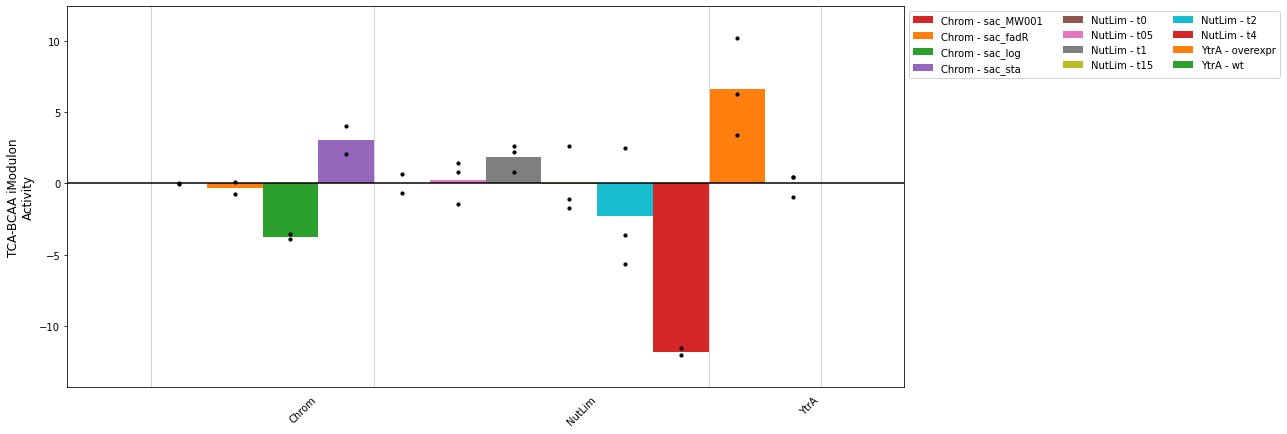

In [82]:
fig, ax = plt.subplots(figsize=(15, 7))

plot_activities(ica_data, 'TCA-BCAA', projects=['Chrom', 'NutLim', 'YtrA'],
                highlight=['Chrom', 'NutLim', 'YtrA'], ax=ax)

## To be continued in next notebook